### Global imports

In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

### Encapsulated local imports

In [2]:
# TODO: remove after debug

%load_ext autoreload
%autoreload 2

In [19]:
from const import Settings
from data import (
    extract_dataset_globs,
    get_labels,
    get_train_transforms,
    get_test_transforms,
    CatsDogsDataset
)

## Process the Cats&Dogs dataset into the runtime

In [9]:
train_list, test_list = extract_dataset_globs()

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [12]:
labels = get_labels(train_list)

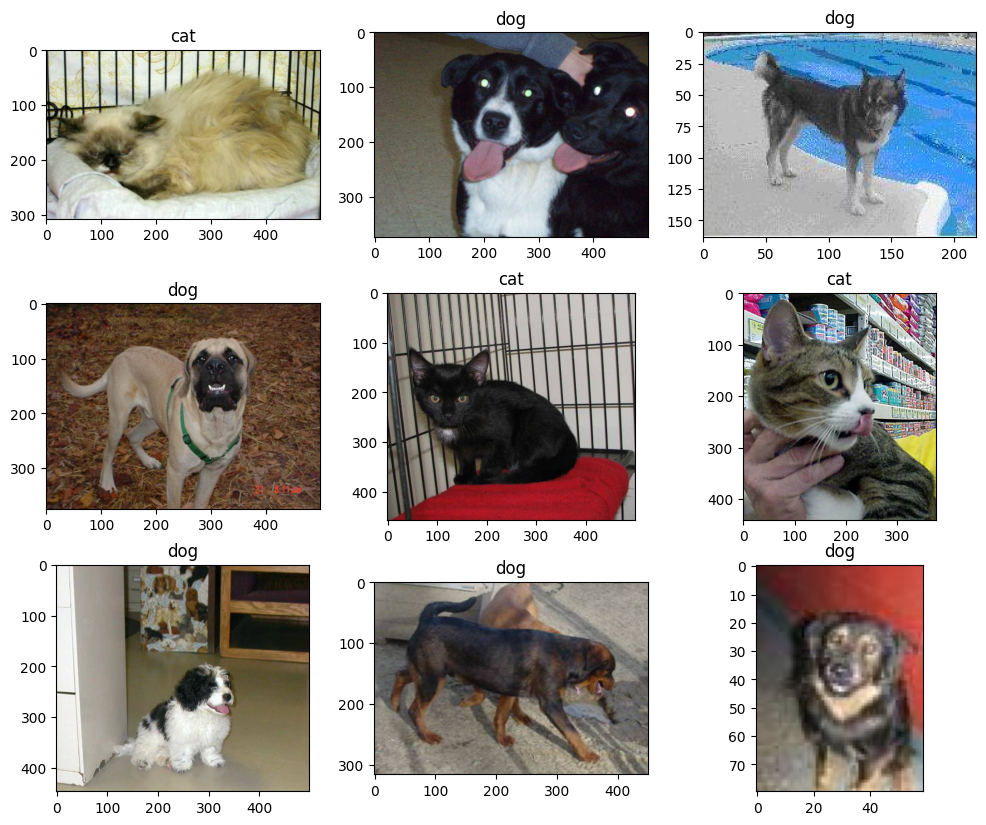

In [15]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Preprocessing

In [23]:
train_list, valid_list = train_test_split(
    train_list, test_size=0.2, stratify=labels, random_state=Settings.seed
)

In [24]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [25]:
train_transforms = get_train_transforms()
test_transforms = get_test_transforms()
# TODO: не будет ли бага из-за неявного копирования?
val_transforms = get_test_transforms()

In [26]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [28]:
train_loader = DataLoader(dataset=train_data, batch_size=Settings.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=Settings.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=Settings.batch_size, shuffle=True)

## Modelling

### Visual transformer initialization

In [29]:
from vit_pytorch.vit import ViT


model = ViT(
    dim=16,
    mlp_dim=16, # TODO: prev dim ?
    depth=1,
    heads=1,
    image_size=224,
    patch_size=32,
    num_classes=2,
    channels=3,
).to(Settings.device)

## Training

In [24]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [39]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=Settings.gamma)

In [41]:
for epoch in range(Settings.epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for i, (data, label) in tqdm(enumerate(train_loader)):
        # TODO: remove later
        if i > 10:
            break
        data = data.to(Settings.device)
        label = label.to(Settings.device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(Settings.device)
            label = label.to(Settings.device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

0it [00:00, ?it/s]

Epoch : 1 - loss : 0.0246 - acc: 0.0184 - val_loss : 0.7046 - val_acc: 0.4958



0it [00:00, ?it/s]

Epoch : 2 - loss : 0.0245 - acc: 0.0182 - val_loss : 0.7014 - val_acc: 0.4972



0it [00:00, ?it/s]

Epoch : 3 - loss : 0.0246 - acc: 0.0173 - val_loss : 0.6984 - val_acc: 0.5028



0it [00:00, ?it/s]

Epoch : 4 - loss : 0.0248 - acc: 0.0165 - val_loss : 0.6975 - val_acc: 0.4986



0it [00:00, ?it/s]

KeyboardInterrupt: 

## Simple profiling